In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# First Step:
#### Data Ingestion-- We load the train and test datasets read the data

In [2]:
df=pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
df2=pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
df2.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


# Data Visualisation
Here we use <i>pandas-profiling</i> library to perform automated data visualisation/EDA for the dataset. One can scroll the profile report generate to draw insights from the summary of the dataset and perform tasks accordingly. We shall be applying the insights later in the notebook

In [4]:
!pip install pandas-profiling
import warnings
warnings.filterwarnings('ignore')
from pandas_profiling import ProfileReport
profile=ProfileReport(df,title='Dataset Report')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 42.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.9.3 which is incompatible.


In [5]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Few Insights
* There are a lot of missing values in the dataset- infact excluding the PassengerId and Transported columns, all other featires have missing values, however no duplicate rows.
* There are 5 Categorical columns 3 Boolean	columns and	6 Numeric columns
* PassengerId,Cabin,Name is uniformly distributed
* There is high correlation between Spa and VRDeck features.   
<i>For remaining insights, view the full profile report</i>

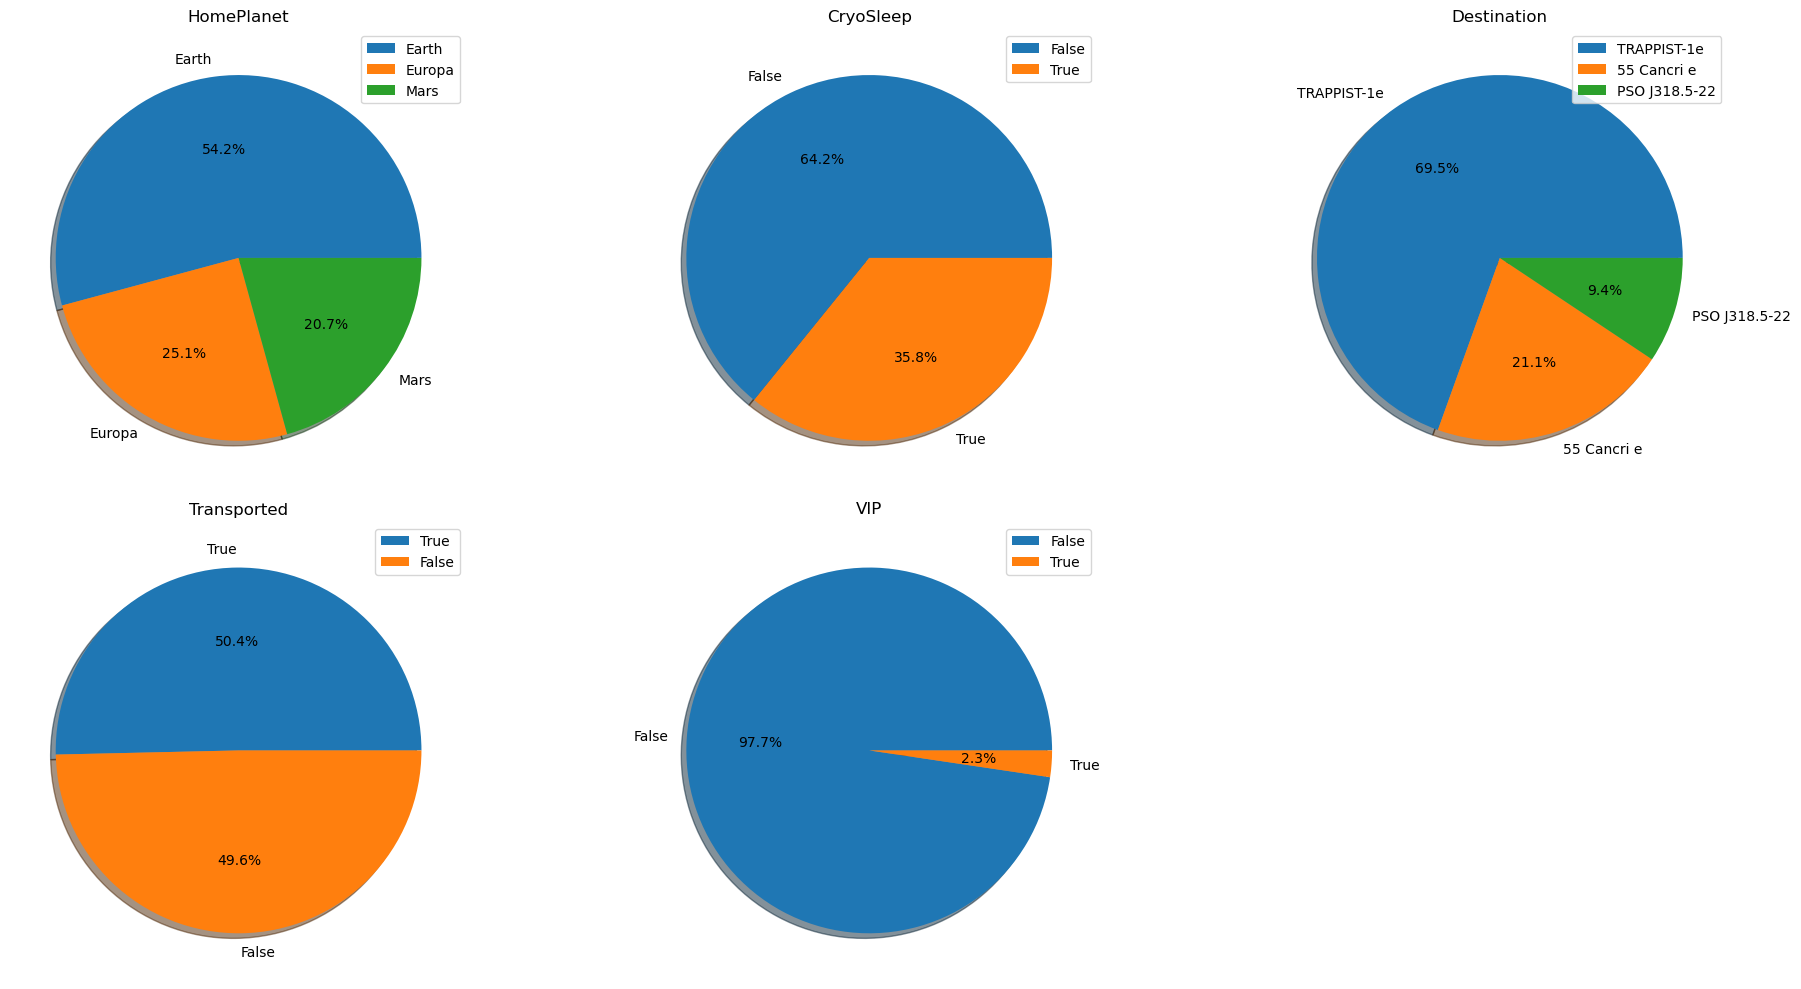

In [6]:
import matplotlib.pyplot as plt
pie_cols=['HomePlanet','CryoSleep','Destination','Transported','VIP']
plt.figure(figsize=(20,10))
for i,col in enumerate(pie_cols):
    counts = df[col].value_counts()
    plt.subplot(2,3,i+1)
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%',shadow=True)
    plt.title(col)
    plt.legend(loc='best')
    plt.tight_layout()
plt.show()

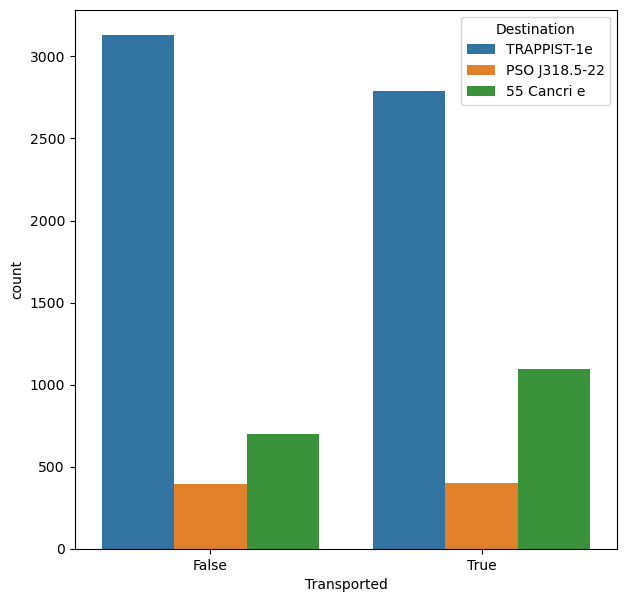

In [7]:
import seaborn as sns
plt.figure(figsize=(7,7))
sns.countplot(x='Transported',hue='Destination',data=df)
plt.show()

In [8]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

#### We'll have to perform imputation for the null values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


#### A general overview of the features

# Data Cleaning and Feature Engineerng

In [10]:
df['Cabin']=df['Cabin'].str.replace('/','')
df['PassengerId']=df['PassengerId'].str.replace('_','')
df['Destination']=df['Destination'].str.replace('-','')
df['CryoSleep'] = df['CryoSleep'].astype(str).replace({'False': 0, 'True': 1}) # replace True and False with 1 and 0
df['VIP'] = df['VIP'].astype(str).replace({'False': 0, 'True': 1})
df.drop(['PassengerId','Name'],axis=1,inplace=True) # we drop the features, Name and PassengerId as they wont really help us with our 
                                                    # predictions. They are only used to identify individual rows
df.head(4)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,0,B0P,TRAPPIST1e,39.0,0,0.0,0.0,0.0,0.0,0.0,False
1,Earth,0,F0S,TRAPPIST1e,24.0,0,109.0,9.0,25.0,549.0,44.0,True
2,Europa,0,A0S,TRAPPIST1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,0,A0S,TRAPPIST1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False


#### Perform some data cleaning for our features

#### Doing the same for our test data

In [11]:
df2['Cabin']=df2['Cabin'].str.replace('/','')
df2['PassengerId']=df2['PassengerId'].str.replace('_','')
df2['Destination']=df2['Destination'].str.replace('-','')
df2['CryoSleep'] = df2['CryoSleep'].astype(str).replace({'False': 0, 'True': 1})
df2['VIP'] = df2['VIP'].astype(str).replace({'False': 0, 'True': 1})
df2.drop(['PassengerId','Name'],axis=1,inplace=True)
df2.head(4)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Earth,1,G3S,TRAPPIST1e,27.0,0,0.0,0.0,0.0,0.0,0.0
1,Earth,0,F4S,TRAPPIST1e,19.0,0,0.0,9.0,0.0,2823.0,0.0
2,Europa,1,C0S,55 Cancri e,31.0,0,0.0,0.0,0.0,0.0,0.0
3,Europa,0,C1S,TRAPPIST1e,38.0,0,0.0,6652.0,0.0,181.0,585.0


In [12]:
num_cols=df.select_dtypes(include=['float64']).columns
cat_cols=df.select_dtypes(include=['object']).columns
print(f'the numerical columns are {num_cols}')
print(f'the categorical columns are {cat_cols}')

the numerical columns are Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')
the categorical columns are Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP'], dtype='object')


### Null value imputation

In [13]:
from sklearn.impute import SimpleImputer

for col in num_cols:
    imp = SimpleImputer(strategy='mean')  #filling null cells for numerical columns with mean values
    df[col] = imp.fit_transform(df[col].values.reshape(-1, 1))

for col in cat_cols:
    imp = SimpleImputer(strategy='most_frequent')
    df[col] = imp.fit_transform(df[col].values.reshape(-1, 1)) #filling null cells for categorical columns with median values

df.isnull().sum()

HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

In [14]:
for col in num_cols:
    imp = SimpleImputer(strategy='mean')
    df2[col] = imp.fit_transform(df2[col].values.reshape(-1, 1)) #filling null cells for numerical columns with mean values

for col in cat_cols:
    imp = SimpleImputer(strategy='most_frequent')
    df2[col] = imp.fit_transform(df2[col].values.reshape(-1, 1)) #filling null cells for categorical columns with median values

df2.isnull().sum()

HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

#### Feature Selection: Performing Principal Component Decomposition for the highly correlated features

In [15]:
from sklearn.decomposition import PCA

correlated_cols = ['FoodCourt', 'VRDeck']
correlated_data = df[correlated_cols]

# Perform PCA
pca = PCA(n_components=1)
reduced_data = pca.fit_transform(correlated_data)

# Replace the correlated columns with the reduced dimensionality column
df['correlated_reduced'] = reduced_data

# Drop the original correlated columns
df.drop(correlated_cols, axis=1, inplace=True) 

In [16]:
correlated_data = df2[correlated_cols]

# Perform PCA
pca = PCA(n_components=1)
reduced_data = pca.fit_transform(correlated_data)

# Replace the correlated columns with the reduced dimensionality column
df2['correlated_reduced'] = reduced_data

# Drop the original correlated columns
df2.drop(correlated_cols, axis=1, inplace=True) 

In [17]:
X,y=df.drop(['Transported'],axis=1),df['Transported']
X

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,ShoppingMall,Spa,correlated_reduced
0,Europa,0,B0P,TRAPPIST1e,39.0,0,0.0,0.0,0.0,-525.503760
1,Earth,0,F0S,TRAPPIST1e,24.0,0,109.0,25.0,549.0,-504.449159
2,Europa,0,A0S,TRAPPIST1e,58.0,1,43.0,0.0,6715.0,2918.892316
3,Europa,0,A0S,TRAPPIST1e,33.0,0,0.0,371.0,3329.0,759.798009
4,Earth,0,F1S,TRAPPIST1e,16.0,0,303.0,151.0,565.0,-457.786087
...,...,...,...,...,...,...,...,...,...,...
8688,Europa,0,A98P,55 Cancri e,41.0,1,0.0,0.0,1643.0,6037.056619
8689,Earth,1,G1499S,PSO J318.522,18.0,0,0.0,0.0,0.0,-525.503760
8690,Earth,0,G1500S,TRAPPIST1e,26.0,0,0.0,1872.0,1.0,-525.503760
8691,Europa,0,E608S,55 Cancri e,32.0,0,0.0,0.0,353.0,1394.032056


In [18]:
y

0       False
1        True
2       False
3       False
4        True
        ...  
8688    False
8689    False
8690     True
8691    False
8692     True
Name: Transported, Length: 8693, dtype: bool

In [19]:
num_cols=df.select_dtypes(include=['float64']).columns
num_cols

Index(['Age', 'RoomService', 'ShoppingMall', 'Spa', 'correlated_reduced'], dtype='object')

In [20]:
cat_cols=cat_cols.drop('Cabin')
cat_cols

Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP'], dtype='object')

# Feature Scaling 

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.25)

# X_train.drop(['Cabin'])
# X_test.drop(['Cabin'])

X_train[cat_cols] = X_train[cat_cols].astype(str)
X_test[cat_cols] = X_test[cat_cols].astype(str)
df2[cat_cols] = df2[cat_cols].astype(str)

# Scale the numerical columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
df2[num_cols] = scaler.transform(df2[num_cols])

# Create an instance of LabelEncoder for encoding categorical features
encoder = LabelEncoder()

# Fit the label encoder on the training set and transform both training and test sets
for col in cat_cols:
    encoder.fit(X_train[col])
    X_train[col] = encoder.transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])
    df2[col] = encoder.transform(df2[col])

# Create an instance of LabelEncoder for encoding the target variable
target_encoder = LabelEncoder()

# Fit the label encoder on the training set target variable and transform both training and test sets
y_train_encoded = target_encoder.fit_transform(y_train)
y_test_encoded = target_encoder.transform(y_test)

# Concatenate the encoded and scaled DataFrames
X_train_processed = pd.concat([X_train[cat_cols], X_train[num_cols]], axis=1)
X_test_processed = pd.concat([X_test[cat_cols], X_test[num_cols]], axis=1)
df2_processed = pd.concat([df2[cat_cols], df2[num_cols]], axis=1)

X_train_processed.head(4)

,HomePlanet,CryoSleep,Destination,VIP,Age,RoomService,ShoppingMall,Spa,correlated_reduced
5623,2,0,2,0,-0.128871,0.326853,0.361855,0.140781,-0.326264
5253,1,1,0,0,1.125483,-0.333284,-0.285595,-0.284249,-0.326264
478,1,1,2,0,1.473915,-0.333284,-0.285595,-0.284249,-0.326264
1352,0,1,2,0,-1.940715,-0.333284,-0.285595,-0.284249,-0.326264


In [22]:
df2_processed.head(4)

,HomePlanet,CryoSleep,Destination,VIP,Age,RoomService,ShoppingMall,Spa,correlated_reduced
0,0,1,2,0,-0.128871,-0.333284,-0.285595,-0.284249,-0.330599
1,0,0,2,0,-0.686361,-0.333284,-0.285595,2.263225,-0.325646
2,1,1,0,0,0.149875,-0.333284,-0.285595,-0.284249,-0.330599
3,1,0,2,0,0.637679,-0.333284,-0.285595,-0.120914,3.494004


# Model Builing, using Gaussian Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB
model=GaussianNB()
model.fit(X_train_processed,y_train_encoded)
y_pred=model.predict(X_test_processed)
y_pred[:]

array([1, 1, 1, ..., 1, 1, 1])

In [24]:
from sklearn.metrics import accuracy_score
score=accuracy_score(y_pred,y_test)
score

0.6821527138914444

# Performing Hyperparameter tuning for the Gaussian Naive Bayes model

In [25]:
from sklearn.model_selection import GridSearchCV

nb_params = {'var_smoothing': [0.2, 0.4, 0.5, 0.6,0.3]}
clf_nb = GaussianNB()
grid_search = GridSearchCV(clf_nb, param_grid=nb_params, cv=5, return_train_score=False)
grid_search.fit(X_train_processed, y_train_encoded)
best_estimator = grid_search.best_estimator_
grid_search.best_score_

0.6594597648654121

In [26]:
grid_search.best_params_

{'var_smoothing': 0.2}

In [27]:
model=GaussianNB(var_smoothing=0.2)
model.fit(X_train_processed,y_train_encoded)
y_pred=model.predict(X_test_processed)
score=accuracy_score(y_pred,y_test)
score

0.6596136154553818

# Building,Testing and tuning various other models

In [28]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

model_names=['svm','random_forest','logistic_regression','gradient_boosting','XGBoost_Classifier']

svm=svm.SVC(gamma='auto',probability=False)
random_forest=RandomForestClassifier()
logistic_regression=LogisticRegression(solver='liblinear',multi_class='auto')
gradient_boosting=GradientBoostingClassifier()

models=[svm,random_forest,logistic_regression,gradient_boosting]
model_params = [{'svc__C': [1, 10, 100, 0.1], 'svc__kernel': ['rbf', 'linear']},
                {'randomforestclassifier__n_estimators': [1, 5, 10]},
                {'logisticregression__C': [1, 5, 10], 'logisticregression__penalty': ['l1', 'l2', 'elasticnet']},
                {'gradientboostingclassifier__n_estimators': [50, 100, 200], 'gradientboostingclassifier__learning_rate': [0.1, 0.5, 1.0]}]

In [29]:
scores = []
best_estimators = {}

for algo, model, params in zip(model_names, models, model_params):
    pipe = make_pipeline(StandardScaler(), model)
    clf = GridSearchCV(pipe, params, cv=5, return_train_score=False)
    clf.fit(X_train_processed, y_train_encoded)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

res = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
res

,model,best_score,best_params
0,svm,0.764536,"{'svc__C': 100, 'svc__kernel': 'rbf'}"
1,random_forest,0.748889,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.750425,"{'logisticregression__C': 1, 'logisticregressi..."
3,gradient_boosting,0.775581,{'gradientboostingclassifier__learning_rate': ...


In [30]:
best_estimators['logistic_regression']

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, solver='liblinear'))])

In [31]:
best_estimators['gradient_boosting']

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [32]:
from xgboost import XGBClassifier
xgb=XGBClassifier()
xgb_params={'max_depth': range(3,10,1),
            'n_estimators':[50,100,130],
            'random_state':[0,50,100]}
clf_xgb=GridSearchCV(xgb, param_grid=xgb_params, cv=5, return_train_score=False)
clf_xgb.fit(X_train_processed, y_train_encoded)
clf_xgb.best_score_

0.773280395877376

In [33]:
clf_xgb.best_params_

{'max_depth': 3, 'n_estimators': 50, 'random_state': 0}

In [34]:
xgb=XGBClassifier(max_depth=3,n_estimators=50,random_state=0)
xgb.fit(X_train_processed, y_train_encoded)
y_pred=xgb.predict(X_test_processed)
score=accuracy_score(y_pred,y_test)
score

0.7543698252069917

# Voting classifier

In [35]:
from sklearn.ensemble import VotingClassifier
from sklearn import svm

voting_clf = VotingClassifier(estimators=[('SVC', svm.SVC(gamma='auto',probability=False,C=100,kernel='rbf')), 
                                          ('random forest', RandomForestClassifier(n_estimators=10)), 
                                          ('logistic regression', LogisticRegression(C=1, solver='liblinear')),
                                          ('gradient boosting',GradientBoostingClassifier()),
                                          ('XGB Classifier',XGBClassifier(max_depth=3,n_estimators=50,random_state=0)),
                                          ('GaussianNB',GaussianNB(var_smoothing=0.2))], voting='hard')

# Fit the voting classifier on the training data
voting_clf.fit(X_train_processed, y_train_encoded)

# Make predictions using the voting classifier
y_pred = voting_clf.predict(X_test_processed)

accuracy = accuracy_score(y_test_encoded, y_pred)
print("Voting Classifier Accuracy:", accuracy)

Voting Classifier Accuracy: 0.7580496780128795


##### Around 76 % accuracy has been achieved

In [36]:
sub=pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
sub.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


# Submission

In [37]:
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission_id = test_df.PassengerId
predictions = voting_clf.predict(df2_processed)
n_predictions = (predictions > 0.5).astype(bool)
output=pd.DataFrame({'PassengerId': submission_id,'Transported': n_predictions.squeeze()})
output.head(4)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True


In [38]:
sample_submission_df = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
sample_submission_df['Transported'] = n_predictions
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
